## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split

from scipy.optimize import fmin_tnc
import scipy.optimize as opt

import statsmodels.api as sm
import statsmodels.formula.api as smf


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklego.preprocessing import InformationFilter
from sklego.linear_model import DemographicParityClassifier
from sklearn.linear_model import LogisticRegression
from sklego.metrics import p_percent_score

from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
warnings.filterwarnings("ignore")


## Read Data

In [3]:
train = pd.read_csv('train data.csv')
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Data Exploration and Pre-processing

In [4]:
train_original=train.copy()

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
train['Loan_Status'].value_counts()

Y    406
N    208
Name: Loan_Status, dtype: int64

### Missing Values Analysis

In [7]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [9]:
train.describe(include=['object'])

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001002,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,406


### Missing value imputation

In [10]:
train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
train['Married'].fillna(train['Married'].mode()[0], inplace=True)
train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)

In [11]:
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)

In [12]:
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)

In [13]:
train['LoanAmount_log']=np.log(train['LoanAmount'])

In [14]:
# replace values in dependent variable to convert into binary variable
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)

In [15]:
#drop unrequired column
train=train.drop('Loan_ID',axis=1)

In [16]:
X1 = train.drop(['Gender'],1)
y1 = train.Gender

# add dummies for categorical variables
X1 = pd.get_dummies(X1,drop_first=True)
y1 =pd.get_dummies(y1,drop_first=True)

# train-test split
x_train1, x_val1, y_train1, y_val1 = train_test_split(X1,y1, test_size=0.3,random_state=7)

In [17]:
X2 = train.drop('Loan_Status',1)
y2 = train.Loan_Status

# add dummies for categorical variables
X2 = pd.get_dummies(X2,drop_first=True)
y2 = pd.get_dummies(y2,drop_first=True)

x_train2, x_val2, y_train2, y_val2 = train_test_split(X2,y2, test_size=0.3,random_state=7)

train2 = x_train2.copy()
train2['Loan_Status'] = y2


In [18]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1,4.852030
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,4.852030
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,4.189655
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4.787492
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,4.948760


<AxesSubplot:xlabel='Gender', ylabel='count'>

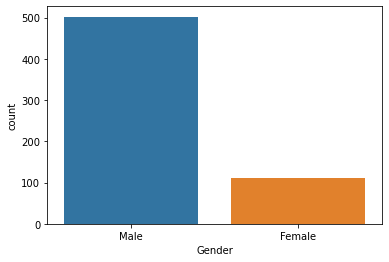

In [57]:
sns.countplot(x='Gender', data=train)

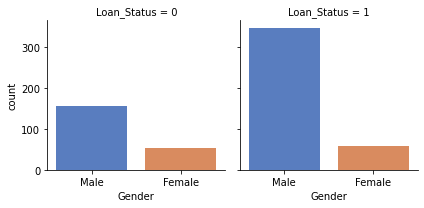

In [59]:
g = sns.FacetGrid(data=train, col='Loan_Status')
g.map(sns.countplot, 'Gender', palette = 'muted')

In [65]:
# Crosstab with "normalize = 'index'". 
df_percent = pd.crosstab(train['Gender'],train['Loan_Status'],
                         normalize = 'index').rename_axis(None)

# Multiply all percentages by 100 for graphing. 
df_percent *= 100
df_percent

Loan_Status,0,1
Female,47.321429,52.678571
Male,30.876494,69.123506


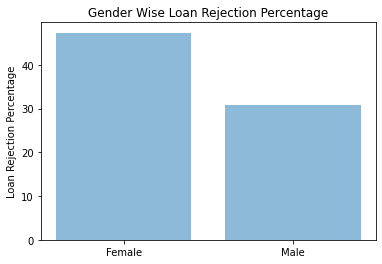

In [76]:
# Plot only approvals as bar graph. 
plt.bar(df_percent.index, df_percent[0], align='center', alpha=0.5)
plt.ylabel('Loan Rejection Percentage')
plt.title('Gender Wise Loan Rejection Percentage')

plt.show()

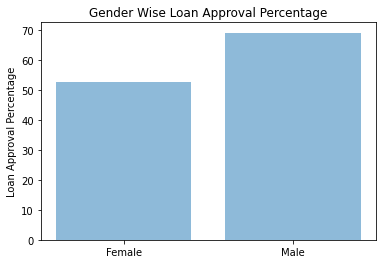

In [73]:
# Plot only approvals as bar graph. 
plt.bar(df_percent.index, df_percent[1], align='center', alpha=0.5)
plt.ylabel('Loan Approval Percentage')
plt.title('Gender Wise Loan Approval Percentage')

plt.show()

In [19]:
#function to calculate TP, FP, TN, FN
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [20]:
def cal_metrics(x_val):
    TP_F, FP_F, TN_F, FN_F = perf_measure((list(x_val['Actual'][x_val['Gender_Male']==0])),list(x_val[x_val['Gender_Male']==0]['Pred']))

    TP_M, FP_M, TN_M, FN_M = perf_measure((list(x_val['Actual'][x_val['Gender_Male']==1])),list(x_val[x_val['Gender_Male']==1]['Pred']))

    𝑃𝑃𝑉 = (𝑇𝑃_𝑀/(𝑇𝑃_𝑀 + 𝐹𝑃_𝑀)) - (𝑇𝑃_F / (𝑇𝑃_F + 𝐹𝑃_F))
    print('The PPV value for Model is:',PPV)

    TP, FP, TN, FN= perf_measure((list(x_val['Actual'])),list(x_val['Pred']))

    Sensitivity = (TP/(TP+FN))
    Specificity = (TN/(TN+FP))

    print('Sensitivity:',Sensitivity)
    print('Specificity:',Specificity)

    Profit = 1262 * TP - 1000 * FP
    print('The profit is:',Profit)
    
    return PPV, Sensitivity, Specificity, Profit


# Model to Predict Loan Status

In [21]:
# building the model and fitting the data
log_reg_LS = sm.Logit(y_train2,x_train2).fit()

# printing the summary table
print(log_reg_LS.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      1   No. Observations:                  429
Model:                          Logit   Df Residuals:                      414
Method:                           MLE   Df Model:                           14
Date:                Sat, 26 Mar 2022   Pseudo R-squ.:                     inf
Time:                        16:59:10   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ApplicantIncome         -1.176e-05   2.82e-05     -0.417      0.677    -6.7e-05    4.35

In [22]:
y_pred_LS = log_reg_LS.predict(x_val2)
y_pred_LS = (y_pred_LS >= 0.5).astype(int)
x_val2['Pred'] = y_pred_LS
x_val2['Actual'] = y_val2
accuracy = np.mean(x_val2['Pred'] == x_val2['Actual'])
print('The accuracy of the model is :',accuracy)

The accuracy of the model is : 0.8


In [23]:
cal_metrics(x_val2)
x_val2 = x_val2.drop(columns=['Pred', 'Actual'])

The PPV value for Model is: 0.19283106538333883
Sensitivity: 0.9834710743801653
Specificity: 0.453125
The profit is: 115178


### Assumptions for revenue and cost

Assume the following for the loans given to the loan applicant
- Loan amount = $1000
- Interest rate = 6%
- Years = 4 years

This means, total principle amount after adding the compound interest is ~1262. 

Further, it has been assumed that the True Positive (i.e. predicted and the actualis sanctioning of loan) are not defaulter and are able to pay back the loan. This means the revenue generated from these will be equal to 1262. 
On the other hand, it has been assumed that the False Positive (predicted as giving loan, but actual was no loan given) are defaulters and will not pay the amount back. This means the cost of giving them loan is equal to the principle amount, 1000. 

For simplicity, it is assumed that there is no cost associated with not giving loan to False Negative segment. 

Therefore, the profit of the bank will be as follows:

$$ P= 1262(TP) - 1000(FP) $$



# Model to Predict Loan Status without Gender

In [24]:
# building the model and fitting the data
log_reg_LS_Without_Gender = smf.logit(formula='Loan_Status ~ ApplicantIncome+CoapplicantIncome+LoanAmount+Loan_Amount_Term+Credit_History+LoanAmount_log+Married_Yes+Dependents_1+Dependents_2+Self_Employed_Yes+Property_Area_Semiurban+Property_Area_Urban', data = train2).fit()

# printing the summary table
print(log_reg_LS_Without_Gender.summary())

Optimization terminated successfully.
         Current function value: 0.490913
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  429
Model:                          Logit   Df Residuals:                      416
Method:                           MLE   Df Model:                           12
Date:                Sat, 26 Mar 2022   Pseudo R-squ.:                  0.2307
Time:                        16:59:10   Log-Likelihood:                -210.60
converged:                       True   LL-Null:                       -273.75
Covariance Type:            nonrobust   LLR p-value:                 3.402e-21
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -5.9378      2.170     -2.737      0.006     -10.190   

In [25]:
y_pred_LS_Without_Gender = log_reg_LS_Without_Gender.predict(x_val2)
y_pred_LS_Without_Gender = (y_pred_LS_Without_Gender >= 0.5).astype(int)
x_val2['Pred'] = y_pred_LS_Without_Gender
x_val2['Actual'] = y_val2
accuracy = np.mean(x_val2['Pred'] == x_val2['Actual'])
print('The accuracy of the model is :',accuracy)

The accuracy of the model is : 0.8


In [26]:
cal_metrics(x_val2)

x_val2 = x_val2.drop(columns=['Pred', 'Actual'])


The PPV value for Model is: 0.22435897435897434
Sensitivity: 0.9834710743801653
Specificity: 0.453125
The profit is: 115178


# Model to Predict Gender

## Logistic Regression

In [27]:
# building the model and fitting the data
log_reg_G = sm.Logit(y_train1, x_train1).fit()

# printing the summary table
print(log_reg_G.summary())

Optimization terminated successfully.
         Current function value: 7.377046
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   Male   No. Observations:                  429
Model:                          Logit   Df Residuals:                      414
Method:                           MLE   Df Model:                           14
Date:                Sat, 26 Mar 2022   Pseudo R-squ.:                     inf
Time:                        16:59:10   Log-Likelihood:                -3164.8
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ApplicantIncome             0.0001   6.89e-05      2.091      0.036    9.05e-06   

In [28]:
y_pred_G = log_reg_G.predict(x_val1)
y_pred_G = (y_pred_G >= 0.5).astype(int)
x_val1['Pred'] = y_pred_G
x_val1['Actual'] = y_val1
accuracy = np.mean(x_val1['Pred'] == x_val1['Actual'])
print('The accuracy of the model is :',accuracy)

The accuracy of the model is : 0.8108108108108109


In [29]:
TP, FP, TN, FN= perf_measure((list(x_val1['Actual'])),list(x_val1['Pred']))

Sensitivity = (TP/(TP+FN))
Specificity = (TN/(TN+FP))

print('Sensitivity:',Sensitivity)
print('Specificity:',Specificity)

x_val1 = x_val1.drop(columns=['Pred', 'Actual'])



Sensitivity: 0.9038461538461539
Specificity: 0.3103448275862069


## Random Forest 

In [30]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train1, y_train1);

In [31]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# Saving feature names 
feature_list = list(x_train1.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: ApplicantIncome      Importance: 0.27
Variable: Married_Yes          Importance: 0.17
Variable: CoapplicantIncome    Importance: 0.12
Variable: LoanAmount           Importance: 0.11
Variable: LoanAmount_log       Importance: 0.11
Variable: Loan_Amount_Term     Importance: 0.05
Variable: Loan_Status          Importance: 0.03
Variable: Dependents_1         Importance: 0.03
Variable: Property_Area_Semiurban Importance: 0.03
Variable: Credit_History       Importance: 0.02
Variable: Education_Not Graduate Importance: 0.02
Variable: Property_Area_Urban  Importance: 0.02
Variable: Dependents_2         Importance: 0.01
Variable: Self_Employed_Yes    Importance: 0.01
Variable: Dependents_3+        Importance: 0.0


In [32]:
y_pred_G_RF = rf.predict(x_val1)
y_pred_G_RF = (y_pred_G_RF >= 0.5).astype(int)
x_val1['Pred'] = y_pred_G_RF
x_val1['Actual'] = y_val1
accuracy = np.mean(x_val1['Pred'] == x_val1['Actual'])
print('The accuracy of the model is :',accuracy)

The accuracy of the model is : 0.7891891891891892


In [33]:
TP, FP, TN, FN= perf_measure((list(x_val1['Actual'])),list(x_val1['Pred']))

Sensitivity = (TP/(TP+FN))
Specificity = (TN/(TN+FP))

print('Sensitivity:',Sensitivity)
print('Specificity:',Specificity)

x_val1 = x_val1.drop(columns=['Pred', 'Actual'])




Sensitivity: 0.8846153846153846
Specificity: 0.27586206896551724


## Predict Loan Status without Important Variables

In [34]:
# building the model and fitting the data
log_reg_LS_Without_ImpVar = smf.logit(formula='Loan_Status ~ Gender_Male+LoanAmount+Loan_Amount_Term+Credit_History+LoanAmount_log+Dependents_1+Dependents_2+Self_Employed_Yes+Property_Area_Semiurban+Property_Area_Urban', data = train2).fit()

# printing the summary table
print(log_reg_LS_Without_ImpVar.summary())

Optimization terminated successfully.
         Current function value: 0.495109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  429
Model:                          Logit   Df Residuals:                      418
Method:                           MLE   Df Model:                           10
Date:                Sat, 26 Mar 2022   Pseudo R-squ.:                  0.2241
Time:                        16:59:12   Log-Likelihood:                -212.40
converged:                       True   LL-Null:                       -273.75
Covariance Type:            nonrobust   LLR p-value:                 1.431e-21
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -5.9135      2.142     -2.761      0.006     -10.112   

In [35]:
y_pred_LS_Without_ImpVar = log_reg_LS_Without_ImpVar.predict(x_val2)
y_pred_LS_Without_ImpVar = (y_pred_LS_Without_ImpVar >= 0.5).astype(int)
x_val2['Pred'] = y_pred_LS_Without_ImpVar
x_val2['Actual'] = y_val2
accuracy = np.mean(x_val2['Pred'] == x_val2['Actual'])
print('The accuracy of the model is :',accuracy)

The accuracy of the model is : 0.7945945945945946


In [36]:
cal_metrics(x_val2)

x_val2 = x_val2.drop(columns=['Pred', 'Actual'])



The PPV value for Model is: 0.24247491638795993
Sensitivity: 0.9752066115702479
Specificity: 0.453125
The profit is: 113916


# Model to Check Interactions with Gender

In [37]:
# building the model and fitting the data
log_reg_Interactions_G = smf.logit(formula='Loan_Status ~ ApplicantIncome+Gender_Male+CoapplicantIncome+LoanAmount+Loan_Amount_Term+Credit_History+LoanAmount_log+Gender_Male+Married_Yes+Dependents_1+Dependents_2+Self_Employed_Yes+Property_Area_Semiurban+Property_Area_Urban+ApplicantIncome:Gender_Male+Gender_Male:Married_Yes+Gender_Male:Property_Area_Semiurban+Gender_Male:CoapplicantIncome', data = train2).fit()

# printing the summary table
print(log_reg_Interactions_G.summary())

Optimization terminated successfully.
         Current function value: 0.483286
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  429
Model:                          Logit   Df Residuals:                      411
Method:                           MLE   Df Model:                           17
Date:                Sat, 26 Mar 2022   Pseudo R-squ.:                  0.2426
Time:                        16:59:12   Log-Likelihood:                -207.33
converged:                       True   LL-Null:                       -273.75
Covariance Type:            nonrobust   LLR p-value:                 5.300e-20
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -6.1861      2.252 

As we can see the interaction with gender are not significant to predict the loan status.

In [38]:
y_pred_Interactions_G = log_reg_Interactions_G.predict(x_val2)
y_pred_Interactions_G = (y_pred_Interactions_G >= 0.5).astype(int)
x_val2['Pred'] = y_pred_Interactions_G
x_val2['Actual'] = y_val2
accuracy = np.mean(x_val2['Pred'] == x_val2['Actual'])
print('The accuracy of the model is :',accuracy)

The accuracy of the model is : 0.8


In [39]:
cal_metrics(x_val2)

x_val2 = x_val2.drop(columns=['Pred', 'Actual'])

The PPV value for Model is: 0.21678321678321677
Sensitivity: 0.9752066115702479
Specificity: 0.46875
The profit is: 114916


# Regularization with Logistic regression

## Custom Lambda

In [40]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def customWeight(W,L):
    totalPenalty = 0
    for i in range(len(W)):
        totalPenalty += L[i+1] * (W[i] ** 2)
    return totalPenalty

def customGradiantWeight(W,L):
    totalPenalty = []
    for i in range(len(W)):
        totalPenalty.append((L[i+1]/m) * (W[i]))
    return totalPenalty

def lrCostFunction(theta_t, X_t, y_t, lambda_t):
    m = len(y_t)
    J = (-1/m) * (y_t.T @ np.log(sigmoid(X_t @ theta_t)) + (1 - y_t.T) @ np.log(1 - sigmoid(X_t @ theta_t)))
    #reg = (lambda_t/(2*m)) * (theta_t[1:].T @ theta_t[1:])
    reg = customWeight(theta_t[1:],lambda_t)/(2*m)
    J = J + reg
    return J

def lrGradientDescent(theta, X, y, lambda_t):
    m = len(y)
    grad = np.zeros([m,1])
    grad = (1/m) * X.T @ (sigmoid(X @ theta) - y)
    #grad[1:] = grad[1:] + (lambda_t / m) * theta[1:]
    #print('Gradiant value for the vector lamda', grad[1:] + list(i/m for i in customGradiantWeight(theta[1:],lambda_t)) )
    #print('Gradiant value for the fixed lamda', grad[1:] + (20 / m) * theta[1:])
    grad[1:] = grad[1:] + list(i/m for i in customGradiantWeight(theta[1:],lambda_t))
    return grad



In [41]:
(m, n) = x_train2.shape
X3 = x_train2
y3 = np.array(y_train2)
theta = np.zeros((n,1))
#Custom_lmbda =[100,100,20,20,20,20,20,100,20,20,20,20,20,100,20]
#Custom_lmbda =[100,100,10,10,10,10,10,100,10,10,10,10,10,100,10]
#Custom_lmbda =[100,100,1,1,1,1,1,100,1,1,1,1,1,100,1]
#Custom_lmbda =[500,500,100,100,100,100,100,500,100,100,100,100,100,500,100]
#Custom_lmbda =[1000,1000,100,100,100,100,100,1000,100,100,100,100,100,1000,100]
#Custom_lmbda =[100,100,50,50,50,50,50,100,50,50,50,50,50,100,50]
#Custom_lmbda = [200,200,50,50,50,50,50,200,50,50,50,50,50,200,50]
Custom_lmbda  = [150,150,50,50,50,50,50,150,50,50,50,50,50,150,50]
#Custom_lmbda  = [120,120,50,50,50,50,50,120,50,50,50,50,50,120,50]
J = lrCostFunction(theta, X3, y3, Custom_lmbda)
output_regularization = opt.fmin_tnc(func = lrCostFunction, x0 = theta.flatten(), fprime = lrGradientDescent, \
                         args = (X3, y3.flatten(), Custom_lmbda))
theta = output_regularization[0]
pred_regularization = [sigmoid(np.dot(x_val2, theta)) >= 0.5]
x_val2['Pred'] = np.array(pred_regularization).flatten()
x_val2['Actual'] = np.array(y_val2)
accuracy = np.mean(x_val2['Pred'] == x_val2['Actual'])
print('The accuracy of the model is :',accuracy)
cal_metrics(x_val2)
x_val2 = x_val2.drop(columns=['Pred', 'Actual'])

The accuracy of the model is : 0.6918918918918919
The PPV value for Model is: 0.170997920997921
Sensitivity: 0.9834710743801653
Specificity: 0.140625
The profit is: 95178


  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   6.71436935E+05
tnc: fscale = 0.00122039
    1    4  6.701603116986489E-01   2.05739472E+04
    2    7  6.423876011106132E-01   6.64054788E+04
    3   12  6.386013201499564E-01   1.71271691E+03
    4   49  6.138228255036351E-01   1.68664803E+03
    4   91  6.138228255036351E-01   1.68664803E+03
tnc: Linear search failed


In [42]:
warnings.filterwarnings("ignore")
table_Lamda = pd.DataFrame()
for i in [0, 1, 5, 10,20, 50,100, 200, 500]:
    print('___________________________________________________________')
    print('Table for lamda value ', i)
    print('---------------------- Start of',i,'-----------------------')
    (m, n) = x_train2.shape
    X3 = x_train2
    y3 = np.array(y_train2)
    theta = np.zeros((n,1))
    Custom_lmbda =[i]*15
    J = lrCostFunction(theta, X3, y3, Custom_lmbda)
    
    output_regularization = opt.fmin_tnc(func = lrCostFunction, x0 = theta.flatten(), fprime = lrGradientDescent, \
                             args = (X3, y3.flatten(), Custom_lmbda))
    theta = output_regularization[0]
    #print(theta) # theta contains the optimized values
    
    pred_regularization = [sigmoid(np.dot(x_val2, theta)) >= 0.5]
    x_val2['Pred'] = np.array(pred_regularization).flatten()
    x_val2['Actual'] = np.array(y_val2)
    accuracy = np.mean(x_val2['Pred'] == x_val2['Actual'])
    print('The accuracy of the model is :',accuracy)
    
    PPV, Sensitivity, Specificity, Profit  = cal_metrics(x_val2)

    x_val2 = x_val2.drop(columns=['Pred', 'Actual'])
    
    print('---------------------- End of',i,'-------------------------')
    print('___________________________________________________________')
    dict = {'Lamda_value': i, 'Accuracy': accuracy, 'PPV': PPV, 'Sensitivity': Sensitivity, 'Specificity':Specificity,'Profit':Profit }

    table_Lamda = table_Lamda.append(dict, ignore_index = True)

  

___________________________________________________________
Table for lamda value  0
---------------------- Start of 0 -----------------------


  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   6.71436935E+05
tnc: fscale = 0.00122039
    1    4  6.701603115181266E-01   2.05739472E+04
    2    7  6.423871670010654E-01   6.64054708E+04


The accuracy of the model is : 0.8
The PPV value for Model is: 0.19283106538333883
Sensitivity: 0.9834710743801653
Specificity: 0.453125
The profit is: 115178
---------------------- End of 0 -------------------------
___________________________________________________________
___________________________________________________________
Table for lamda value  1
---------------------- Start of 1 -----------------------


    3   12  6.386009074614877E-01   1.71271752E+03
    4   20  4.990874699781180E-01   2.07166284E+03
    5   24  4.947407737725837E-01   7.38857437E+00
tnc: fscale = 0.367891
    6   29  4.947306389567851E-01   4.30395163E-01
    7   33  4.924631695087713E-01   4.88252202E+02
    8   38  4.919316415984128E-01   3.30249143E+01
    9   44  4.913066437137049E-01   5.15854436E+00
   10   49  4.910676961519579E-01   8.03699940E+00
   11   57  4.909624119740887E-01   1.04526655E-01
   12   65  4.909411065990338E-01   2.76747031E+00
   13   72  4.909365561658437E-01   7.13564771E-01
   14   80  4.909362150451164E-01   4.50350565E-02
   15   87  4.909361334713573E-01   7.42805249E-05
tnc: fscale = 116.028
tnc: |fn-fn-1] = 1.87282e-11 -> convergence
   16   90  4.909361334526292E-01   1.46796739E-06
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   6.71436935E+05
tnc: fscale = 0.00122039
    1    4  6.701603115195945E-01   2.057394

The accuracy of the model is : 0.8
The PPV value for Model is: 0.19283106538333883
Sensitivity: 0.9834710743801653
Specificity: 0.453125
The profit is: 115178
---------------------- End of 1 -------------------------
___________________________________________________________
___________________________________________________________
Table for lamda value  5
---------------------- Start of 5 -----------------------
The accuracy of the model is : 0.7945945945945946
The PPV value for Model is: 0.21061762664816097
Sensitivity: 0.9752066115702479
Specificity: 0.453125
The profit is: 113916
---------------------- End of 5 -------------------------
___________________________________________________________
___________________________________________________________
Table for lamda value  10
---------------------- Start of 10 -----------------------


    4   59  5.462055861666969E-01   4.37892208E+03
tnc: Linear search failed
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   6.71436935E+05
tnc: fscale = 0.00122039
    1    4  6.701603115328023E-01   2.05739472E+04
    2    7  6.423872514779274E-01   6.64054532E+04
    3   12  6.386009838746771E-01   1.71271847E+03
    4   20  5.933919473476613E-01   3.59924455E+03
    4   59  5.933919473476613E-01   3.59924455E+03
tnc: Linear search failed
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   6.71436935E+05
tnc: fscale = 0.00122039
    1    4  6.701603115474847E-01   2.05739472E+04
    2    7  6.423873392431604E-01   6.64054809E+04
    3   12  6.386010581269711E-01   1.71271343E+03


The accuracy of the model is : 0.7945945945945946
The PPV value for Model is: 0.21061762664816097
Sensitivity: 0.9752066115702479
Specificity: 0.453125
The profit is: 113916
---------------------- End of 10 -------------------------
___________________________________________________________
___________________________________________________________
Table for lamda value  20
---------------------- Start of 20 -----------------------
The accuracy of the model is : 0.7783783783783784
The PPV value for Model is: 0.20024875621890548
Sensitivity: 0.9834710743801653
Specificity: 0.390625
The profit is: 111178
---------------------- End of 20 -------------------------
___________________________________________________________
___________________________________________________________
Table for lamda value  50
---------------------- Start of 50 -----------------------


    4   48  5.858093683871196E-01   2.49960193E+03
    4   89  5.858093683871196E-01   2.49960193E+03
tnc: Linear search failed
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   6.71436935E+05
tnc: fscale = 0.00122039
    1    4  6.701603115915213E-01   2.05739472E+04
    2    7  6.423875931274385E-01   6.64054520E+04
    3   12  6.386012862066839E-01   1.71271795E+03
    4   49  6.095707920588643E-01   1.70355606E+03
    4   91  6.095707920588643E-01   1.70355606E+03
tnc: Linear search failed
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   6.71436935E+05
tnc: fscale = 0.00122039


The accuracy of the model is : 0.6918918918918919
The PPV value for Model is: 0.170997920997921
Sensitivity: 0.9834710743801653
Specificity: 0.140625
The profit is: 95178
---------------------- End of 50 -------------------------
___________________________________________________________
___________________________________________________________
Table for lamda value  100
---------------------- Start of 100 -----------------------
The accuracy of the model is : 0.6918918918918919
The PPV value for Model is: 0.170997920997921
Sensitivity: 0.9834710743801653
Specificity: 0.140625
The profit is: 95178
---------------------- End of 100 -------------------------
___________________________________________________________
___________________________________________________________
Table for lamda value  200
---------------------- Start of 200 -----------------------


    1    4  6.701603116649190E-01   2.05739472E+04
    2    7  6.423880217552197E-01   6.64054707E+04
    3   12  6.386016634999651E-01   1.71271079E+03
    4   49  6.381214845739538E-01   1.72672395E+03
    4   91  6.381214845739538E-01   1.72672395E+03
tnc: Linear search failed
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   6.71436935E+05
tnc: fscale = 0.00122039
    1    4  6.701603118117103E-01   2.05739472E+04
    2    7  6.423888755907606E-01   6.64054604E+04
    3   12  6.386024196232342E-01   1.71271307E+03
    4   50  6.358316674090359E-01   1.57210480E+03
tnc: fscale = 0.0252208
    5   55  6.356548683754802E-01   2.62699588E-01
tnc: fscale = 1.95106
    6   60  6.356253527731430E-01   1.10690033E+02
tnc: fscale = 0.0950486
    7   82  6.356249259599955E-01   6.23780637E+01
    7  133  6.356249259599955E-01   6.23780637E+01
tnc: Linear search failed
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   6.71436935E+05
tnc: f

The accuracy of the model is : 0.6486486486486487
The PPV value for Model is: 0.20351588911426638
Sensitivity: 0.9834710743801653
Specificity: 0.015625
The profit is: 87178
---------------------- End of 200 -------------------------
___________________________________________________________
___________________________________________________________
Table for lamda value  500
---------------------- Start of 500 -----------------------
The accuracy of the model is : 0.6432432432432432
The PPV value for Model is: 0.19905956112852657
Sensitivity: 0.9834710743801653
Specificity: 0.0
The profit is: 86178
---------------------- End of 500 -------------------------
___________________________________________________________


    6   62  6.347144541972359E-01   1.42918930E+02
tnc: |fn-fn-1] = 0 -> convergence
    7  116  6.347144541972359E-01   1.42918930E+02
tnc: Converged (|f_n-f_(n-1)| ~= 0)


In [43]:
table_Lamda

,Lamda_value,Accuracy,PPV,Sensitivity,Specificity,Profit
0,0.0,0.800000,0.192831,0.983471,0.453125,115178.0
1,1.0,0.800000,0.192831,0.983471,0.453125,115178.0
2,5.0,0.794595,0.210618,0.975207,0.453125,113916.0
3,10.0,0.794595,0.210618,0.975207,0.453125,113916.0
4,20.0,0.778378,0.200249,0.983471,0.390625,111178.0
5,50.0,0.691892,0.170998,0.983471,0.140625,95178.0
6,100.0,0.691892,0.170998,0.983471,0.140625,95178.0
7,200.0,0.648649,0.203516,0.983471,0.015625,87178.0
8,500.0,0.643243,0.199060,0.983471,0.000000,86178.0


## Regularization in build function

In [44]:
df_clf = X2
y_clf = y2

In [45]:
normal_classifier_reg = LogisticRegression(C=50)
normal_classifier_reg.fit(df_clf, y_clf)
y_pred_reg = normal_classifier_reg.predict(x_val2)
x_val2['Pred'] = np.array(y_pred_reg.flatten())
x_val2['Actual'] = np.array(y_val2)

In [46]:
cal_metrics(x_val2)

x_val2 = x_val2.drop(columns=['Pred', 'Actual'])

The PPV value for Model is: 0.19283106538333883
Sensitivity: 0.9834710743801653
Specificity: 0.453125
The profit is: 115178


# Fairness 

## Demographic Parity Classifier

In [47]:
normal_classifier = LogisticRegression()
normal_classifier.fit(df_clf, y_clf)
fair_classifier = DemographicParityClassifier(sensitive_cols="Gender_Male", covariance_threshold=0.5)
fair_classifier.fit(df_clf, y_clf);

In [48]:
y_pred_DPC = fair_classifier.predict(x_val2)
x_val2['Pred'] = np.array(y_pred_DPC).flatten()
x_val2['Actual'] = np.array(y_val2)

In [49]:
cal_metrics(x_val2)

x_val2 = x_val2.drop(columns=['Pred', 'Actual'])

The PPV value for Model is: 0.21819338422391854
Sensitivity: 0.9834710743801653
Specificity: 0.4375
The profit is: 114178


In [50]:
fair_classifier_GridSearch = GridSearchCV(estimator=DemographicParityClassifier(sensitive_cols="Gender_Male",
                                                        covariance_threshold=0.5),
                               param_grid={"estimator__covariance_threshold":
                                           np.linspace(0.01, 1.00, 20)},
                               cv=5,
                               refit="accuracy_score",
                               return_train_score=True,
                               scoring={"p_percent_score": p_percent_score('Gender_Male'),
                                        "accuracy_score": make_scorer(accuracy_score)})

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fair_classifier_GridSearch.fit(df_clf, y_clf);

    pltr = (pd.DataFrame(fair_classifier_GridSearch.cv_results_)
            .set_index("param_estimator__covariance_threshold"))

    p_score = p_percent_score('Gender_Male')(normal_classifier, df_clf, y_clf)
    acc_score = accuracy_score(normal_classifier.predict(df_clf), y_clf)

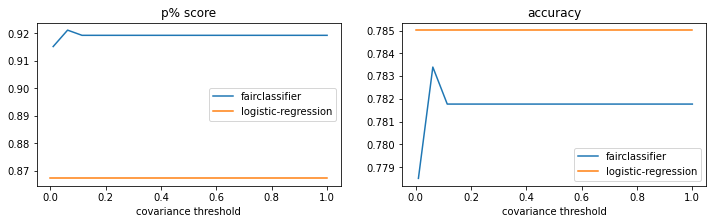

In [51]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(np.array(pltr.index), pltr['mean_test_p_percent_score'], label='fairclassifier')
plt.plot(np.linspace(0, 1, 2), [p_score for _ in range(2)], label='logistic-regression')
plt.xlabel("covariance threshold")
plt.legend()
plt.title("p% score")
plt.subplot(122)
plt.plot(np.array(pltr.index), pltr['mean_test_accuracy_score'], label='fairclassifier')
plt.plot(np.linspace(0, 1, 2), [acc_score for _ in range(2)], label='logistic-regression')
plt.xlabel("covariance threshold")
plt.legend()
plt.title("accuracy");

In [52]:
y_pred_GridSearch = fair_classifier_GridSearch.predict(x_val2)
x_val2['Pred'] = np.array(y_pred_GridSearch).flatten()
x_val2['Actual'] = np.array(y_val2)

In [53]:
cal_metrics(x_val2)
x_val2 = x_val2.drop(columns=['Pred', 'Actual'])

The PPV value for Model is: 0.21819338422391854
Sensitivity: 0.9834710743801653
Specificity: 0.4375
The profit is: 114178


In [54]:
import warnings
from sklego.linear_model import EqualOpportunityClassifier
from sklego.metrics import equal_opportunity_score

y_clf = np.array(y_clf)

fair_classifier_equal = GridSearchCV(
    estimator=EqualOpportunityClassifier(
        sensitive_cols="Gender_Male", 
        covariance_threshold=0.5,
        positive_target=True,
    ),
    param_grid={"estimator__covariance_threshold": np.linspace(0.001, 1.00, 20)},
    cv=5,
    n_jobs=-1,
    refit="accuracy_score",
    return_train_score=True,
    scoring={"p_percent_score": p_percent_score('Gender_Male'),
            "equal_opportunity_score": equal_opportunity_score('Gender_Male'),
            "accuracy_score": make_scorer(accuracy_score)}
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fair_classifier_equal.fit(df_clf, y_clf);

    pltr = (pd.DataFrame(fair_classifier_equal.cv_results_)
            .set_index("param_estimator__covariance_threshold"))

    p_score = p_percent_score('Gender_Male')(normal_classifier, df_clf, y_clf)
    acc_score = accuracy_score(normal_classifier.predict(df_clf), y_clf)

/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklego/metrics.py", line 134, in impl
    y_given_z1_y1 = y_hat[(sensitive_col == 1) & (y_true == positive_target)]
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/common.py", line 69, in new_method
    return method(self, other)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py", line 62,

/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklego/metrics.py", line 134, in impl
    y_given_z1_y1 = y_hat[(sensitive_col == 1) & (y_true == positive_target)]
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/common.py", line 69, in new_method
    return method(self, other)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py", line 62,

/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklego/metrics.py", line 134, in impl
    y_given_z1_y1 = y_hat[(sensitive_col == 1) & (y_true == positive_target)]
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/common.py", line 69, in new_method
    return method(self, other)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py", line 62,

  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py", line 62, in __and__
    return self._logical_method(other, operator.and_)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/series.py", line 5513, in _logical_method
    res_values = ops.logical_op(lvalues, rvalues, op)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py", line 392, in logical_op
    res_values = na_logical_op(lvalues, rvalues, op)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py", line 330, in na_logical_op
    return result.reshape(x.shape)
ValueError: cannot reshape array of size 241081 into shape (491,)

  warnings.warn(
/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File

/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklego/metrics.py", line 134, in impl
    y_given_z1_y1 = y_hat[(sensitive_col == 1) & (y_true == positive_target)]
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/common.py", line 69, in new_method
    return method(self, other)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py", line 62,

    res_values = na_logical_op(lvalues, rvalues, op)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py", line 330, in na_logical_op
    return result.reshape(x.shape)
ValueError: cannot reshape array of size 241081 into shape (491,)

  warnings.warn(
/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklego/metrics.py", line 134, in impl
    y_given_z1_y1 = y_hat[(

  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py", line 62, in __and__
    return self._logical_method(other, operator.and_)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/series.py", line 5513, in _logical_method
    res_values = ops.logical_op(lvalues, rvalues, op)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py", line 392, in logical_op
    res_values = na_logical_op(lvalues, rvalues, op)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py", line 330, in na_logical_op
    return result.reshape(x.shape)
ValueError: cannot reshape array of size 15129 into shape (123,)

  warnings.warn(
/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File 

    res_values = na_logical_op(lvalues, rvalues, op)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py", line 330, in na_logical_op
    return result.reshape(x.shape)
ValueError: cannot reshape array of size 242064 into shape (492,)

  warnings.warn(
/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/Users/syed/opt/anaconda3/lib/python3.9/site-packages/sklego/metrics.py", line 134, in impl
    y_given_z1_y1 = y_hat[(

In [55]:
y_pred_GridSearch = fair_classifier_equal.predict(x_val2)
x_val2['Pred'] = np.array(y_pred_GridSearch).flatten()
x_val2['Actual'] = np.array(y_val2)

In [56]:
cal_metrics(x_val2)
x_val2 = x_val2.drop(columns=['Pred', 'Actual'])

The PPV value for Model is: 0.22916666666666663
Sensitivity: 0.9752066115702479
Specificity: 0.46875
The profit is: 114916
